<a href="https://colab.research.google.com/github/LKSfiuza/Deeplearning/blob/main/%5BELT575_Semana2_118678.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Importando dados

Aqui usaremos o dataset Cifar10 (https://www.tensorflow.org/datasets/catalog/cifar10?hl=pt-br),  consiste em 60.000 imagens coloridas 32x32 em 10 classes, com 6.000 imagens por classe. Existem 50.000 imagens de treinamento e 10.000 imagens de teste, tendo dimensões 32 x 32 x 3

* Usaremos a versão disponível no tensorflow, mas nada impede que as imagens sejam carregadas de alguma pasta no próprio computador ou carregadas direto para a memória como um array multidimensional (esse último é desaconselhado devido ao volume de dados que serão manipulados durante o treinamento da rede)

In [ ]:
# carregando dataset
(trainX, trainY), (testX, testY) = cifar10.load_data()

Faremos algumas adequações para que os dados sejam usados no modelo de CNN. Basicamente, colocamos os valores dos pixels em uma escala de 0 a 1, visto que os valores originais dos pixels das imagens correspondem a uma escala de 0 a 255. Também transformamos nossa variável alvo em uma codificação one-hos

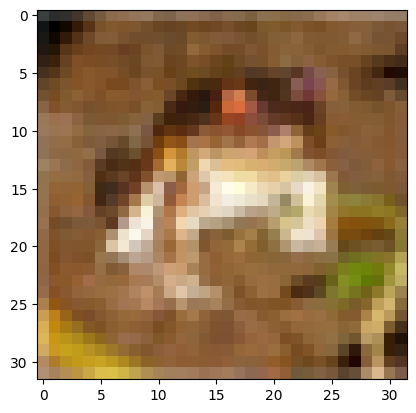

In [ ]:
plt.imshow(trainX[0], cmap='gray');

In [ ]:
# fazendo um reshape no dataset para ter um único canal
##trainX = trainX.reshape((trainX.shape[0], 32, 32, 3))
#testX = testX.reshape((testX.shape[0], 32, 32, 3))

# Convertendo valores dos pixels em float
trainX = trainX.astype('float32')
testX = testX.astype('float32')

# normalização para escala [0-1]
trainX = trainX / 255.0
testX = testX / 255.0

# transformando a variável alvo (target) para uma codificação one hot
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# Construindo o modelo

O modelo usado será bem simples:
* Uma única camada convolucional com 32 filtros de tamanho 3 x 3 e função de ativação ReLU
* Camada MaxPooling para redução de dimensionalidade
* Transformação do resultado em um vetor
* Camada totalmente conectada com 100 neurônios e função de ativação ReLU
* Camada de saída softmax para estimar a probabilidade da entrada da rede pertencer a cada uma das 10 classes


Para treinamento do modelo, usaremos o algoritmo de otimização clássico do gradiente descendente estocástico (SDG), com a função objetiva como a entropia cruzada categórica. Nossa principal métrica de desempenho será a acurácia

In [ ]:
# definindo modelo
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # compilando modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# Treinamento do modelo

O treinamento será realizado usando o método da validação cruzada k-partições (k-fold) com k=5. Tal validação cruzada faz a divisão dos dados em 5 grupos de tamanho igual, sendo realizadas 5 treinamentos distintos. A cada treinamento, 4 grupos de dados são utilizados para treinar o modelo e o grupo remanescente é usado para teste do desempenho do modelo treinado.



* O principal intuito da validação k-fold é acessar a incerteza do desempenho do modelo

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Epoch 1/10
1250/1250 [==============================] - 11s 5ms/step - loss: 1.3749 - accuracy: 0.5162 - val_loss: 1.3309 - val_accuracy: 0.5494
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9971 - accuracy: 0.6479 - val_loss: 1.2173 - val_accuracy: 0.5835
Epoch 3/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.8008 - accuracy: 0.7210 - val_loss: 1.3168 - val_accuracy: 0.5936
Epoch 4/10
1250/1250 [==============================] - 6s 4ms/step - loss: 0.6248 - accuracy: 0.7805 - val_loss: 1.4001 - val_accuracy: 0.5937
Epoch 5/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.4645 - accuracy: 0.8389 - val_loss: 1.5355 - val_accuracy: 0.6013
> 58.350
Epoch 1/10
1250/1250 [==============================] - 9s 6ms/step - loss: 1.3664 - accuracy: 0.5201 - val_loss: 1.2297 - val_accuracy: 0.5746
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9841 - accuracy: 0.6546 - val_loss: 1.1815 - val

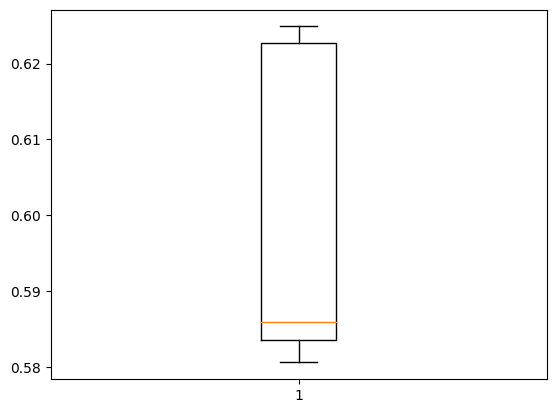

In [ ]:
scores = []
histories = []

# definindo a validação k-fold
kfold = KFold(5, shuffle=True, random_state=1)

# loop para as k-folds (cada fold usa subconjuntos de treino e teste diferentes)
for train_ix, test_ix in kfold.split(trainX):

  model = define_model()

  # recorta dados de acordo com índices da k-fold
  train_data, train_target, val_data, val_target = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]

  # Treinamento do modelo
  history = model.fit(train_data, train_target,
                      epochs=10, batch_size=32,
                      validation_data=(val_data, val_target),
                      verbose=1, callbacks=[callback])

  # desempenho do modelo
  _, acc = model.evaluate(val_data, val_target, verbose=0)
  print('> %.3f' % (acc * 100.0))

  # armazena resultados de cada modelo treinado dentro da k-fold
  scores.append(acc)
  histories.append(history)

print('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores)*100, np.std(scores)*100))
plt.boxplot(scores)
plt.show()

## RESPOSTA 1 : FOI POSSIVEL NOTAR QUE O MODELO OBTEVE ACURÁCIA MEDIA DE 59.952 E UM DESVIO DE 1.991 USANDO EXATAMENTE OS MESMO PARAMETROS DO EXEMPLO UTILIZADO PARA O MNIST

## Experimentando adicionar mais dois blocos de camadas Conv2D (64 filtros 3x3 - relu) + MaxPooling (2 x 2) antes da camada Flatten e compare os resultados.

Epoch 1/10
1250/1250 [==============================] - 10s 6ms/step - loss: 1.3773 - accuracy: 0.5098 - val_loss: 1.3704 - val_accuracy: 0.5374
Epoch 2/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.0377 - accuracy: 0.6354 - val_loss: 1.1806 - val_accuracy: 0.5958
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8820 - accuracy: 0.6902 - val_loss: 1.1473 - val_accuracy: 0.6092
Epoch 4/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7784 - accuracy: 0.7240 - val_loss: 0.9919 - val_accuracy: 0.6628
Epoch 5/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.6920 - accuracy: 0.7564 - val_loss: 0.9530 - val_accuracy: 0.6814
Epoch 6/10
1250/1250 [==============================] - 7s 5ms/step - loss: 0.6271 - accuracy: 0.7786 - val_loss: 1.1707 - val_accuracy: 0.6321
Epoch 7/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.5657 - accuracy: 0.7999 - val_loss: 0.9831 - val_accuracy

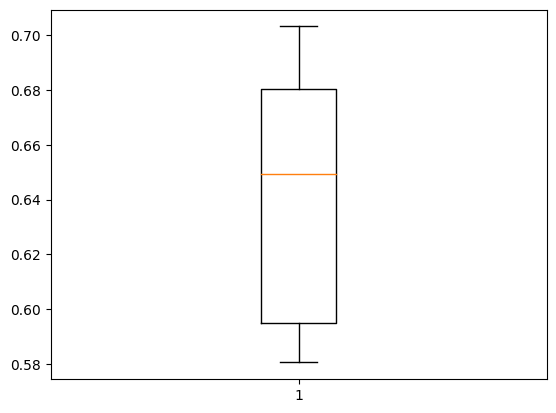

In [ ]:

# Definindo o modelo com camadas adicionais
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # Compilando o modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


for train_ix, test_ix in kfold.split(trainX):
  model = define_model()
  train_data, train_target, val_data, val_target = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]
  history = model.fit(train_data, train_target,
                      epochs=10, batch_size=32,
                      validation_data=(val_data, val_target),
                      verbose=1, callbacks=[callback])
  _, acc = model.evaluate(val_data, val_target, verbose=0)
  print('> %.3f' % (acc * 100.0))
  scores.append(acc)
  histories.append(history)

print('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores)*100, np.std(scores)*100))
plt.boxplot(scores)
plt.show()


## Resposta 2: Depois das alterações recomendadas, foi possível perceber mudanças significativas, como um aumento da acurácia para 64.359. Porém, houve um aumento também do desvio padrão para 4.712, o que pode ser considerado ruim.

## Seguindo o modelo modificado no item anterior, experimente adicionar um Dropout de 20% após cada camada MaxPooling. Comente os resultados obtidos.



Epoch 1/10
1250/1250 [==============================] - 12s 7ms/step - loss: 1.5475 - accuracy: 0.4443 - val_loss: 1.3876 - val_accuracy: 0.5168
Epoch 2/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.2285 - accuracy: 0.5583 - val_loss: 1.2281 - val_accuracy: 0.5614
Epoch 3/10
1250/1250 [==============================] - 7s 6ms/step - loss: 1.0992 - accuracy: 0.6086 - val_loss: 1.1141 - val_accuracy: 0.6058
Epoch 4/10
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0167 - accuracy: 0.6410 - val_loss: 0.9580 - val_accuracy: 0.6592
Epoch 5/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9528 - accuracy: 0.6658 - val_loss: 0.9954 - val_accuracy: 0.6506
Epoch 6/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9057 - accuracy: 0.6812 - val_loss: 0.9900 - val_accuracy: 0.6531
Epoch 7/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.8636 - accuracy: 0.6947 - val_loss: 1.0090 - val_accuracy

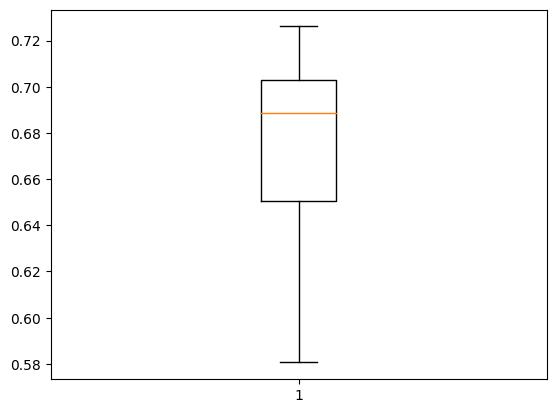

In [ ]:
# Definindo o modelo com camadas adicionais e adicionando um dropout de 0.2 apos todas camadas MaxPooling
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  # Compilando o modelo
  opt = Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


for train_ix, test_ix in kfold.split(trainX):
  model = define_model()
  train_data, train_target, val_data, val_target = trainX[train_ix], trainY[train_ix], trainX[test_ix], trainY[test_ix]
  history = model.fit(train_data, train_target,
                      epochs=10, batch_size=32,
                      validation_data=(val_data, val_target),
                      verbose=1, callbacks=[callback])
  _, acc = model.evaluate(val_data, val_target, verbose=0)
  print('> %.3f' % (acc * 100.0))
  scores.append(acc)
  histories.append(history)

print('Acurácia: média=%.3f desvio=%.3f' % (np.mean(scores)*100, np.std(scores)*100))
plt.boxplot(scores)
plt.show()

## Resposta 3 : Foi possivel notar um pequeno aumento da acúracia e uma diminuição do desvio padrão. Porém avaliando o grafíco ele mostra uma variabilidade muito grande comparado aos gráficos anteriores.